In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from pathlib import Path
from time import time
from typing import Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import (
    extract_matrix_variable_coords,
    summarize_posterior_predictions,
)
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.io import DataFile
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

In [5]:
counts_dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_SUBSAMPLE)
counts_data = counts_dm.get_data()

In [6]:
hnb = HierarchcalNegativeBinomialModel()

In [7]:
valid_counts_data = hnb.data_processing_pipeline(counts_dm.get_data())

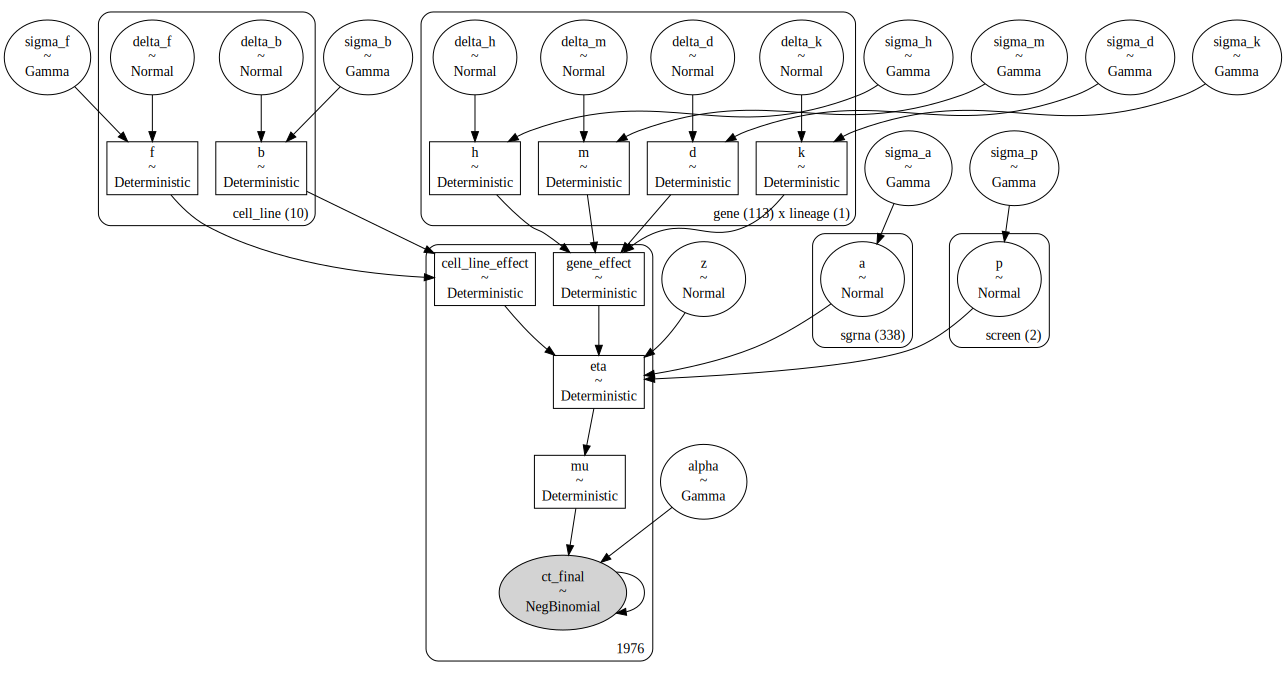

In [8]:
hnb_model = hnb.pymc_model(counts_data)
pm.model_to_graphviz(hnb_model)

In [9]:
with hnb_model:
    trace = pm.sample(draws=500, tune=250, chains=2, cores=2, target_accept=0.95)
    _ = pm.sample_posterior_predictive(trace=trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, sigma_a, a, sigma_b, delta_b, sigma_d, delta_d, sigma_f, delta_f, sigma_h, delta_h, sigma_k, delta_k, sigma_m, delta_m, sigma_p, p, alpha]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 1184 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


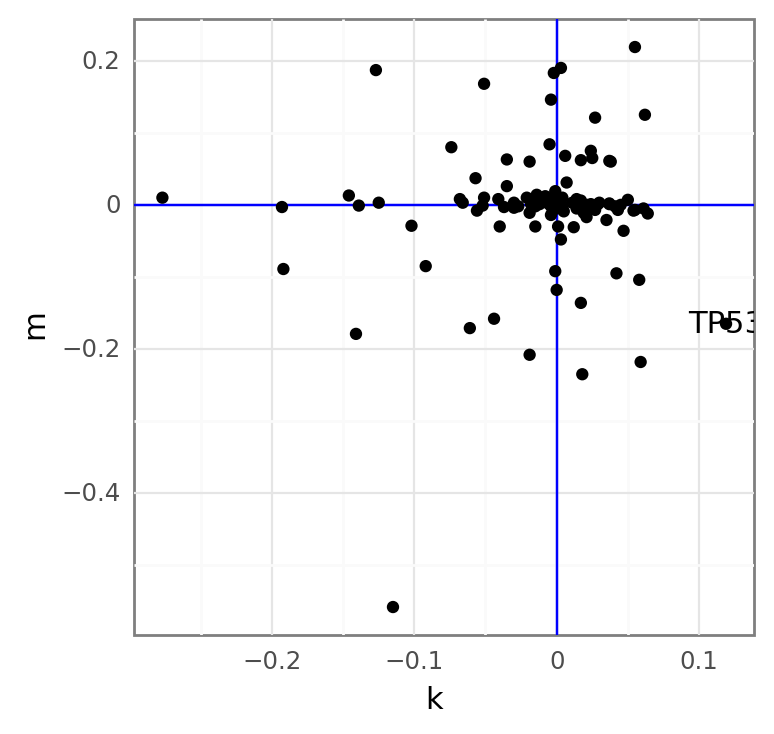

<ggplot: (314493200)>

In [10]:
rna_mut_post = (
    az.summary(trace, var_names=["k", "m"], kind="stats")
    .reset_index(drop=False)
    .pipe(
        extract_matrix_variable_coords,
        col="index",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
    .assign(var_name=lambda d: [x[0] for x in d["index"]])
    .pivot_wider(["hugo_symbol", "lineage"], names_from="var_name", values_from="mean")
)

(
    gg.ggplot(rna_mut_post, gg.aes(x="k", y="m"))
    + gg.geom_vline(xintercept=0, color="b")
    + gg.geom_hline(yintercept=0, color="b")
    + gg.geom_point()
    + gg.geom_text(
        gg.aes(label="hugo_symbol"), data=rna_mut_post.query("k > 0.1 and m < -0.1")
    )
)

## Posterior predictions on new data

In [11]:
counts_data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'p_dna_batch', 'genome_alignment',
       'hugo_symbol', 'screen', 'multiple_hits_on_gene', 'sgrna_target_chr',
       'sgrna_target_pos', 'depmap_id', 'counts_final', 'counts_initial',
       'rna_expr', 'num_mutations', 'any_deleterious', 'any_tcga_hotspot',
       'any_cosmic_hotspot', 'is_mutated', 'copy_number', 'lineage',
       'primary_or_metastasis', 'is_male', 'age'],
      dtype='object')

In [12]:
gene = "TP53"
gene_data = valid_counts_data.query(f"hugo_symbol == '{gene}'").reset_index(drop=True)

keep_cols = [
    "sgrna",
    "hugo_symbol",
    "replicate_id",
    "p_dna_batch",
    "screen",
    "depmap_id",
    "lineage",
    "counts_initial",
    "counts_final",
]
base_gene_df = gene_data[keep_cols].drop_duplicates().reset_index(drop=True)
base_gene_df

,sgrna,hugo_symbol,replicate_id,p_dna_batch,screen,depmap_id,lineage,counts_initial,counts_final
0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,24.509746,810
1,GCAGTCACAGCACATGACGG,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,13.343433,443
2,AATCAACCCACAGCTGCACA,TP53,SNU-1033-311Cas9_RepA_p3_batch3,3,broad,ACH-000286,colorectal,24.509746,1465
3,GCAGTCACAGCACATGACGG,TP53,SNU-1033-311Cas9_RepA_p3_batch3,3,broad,ACH-000286,colorectal,13.343433,377
4,AATCAACCCACAGCTGCACA,TP53,OUMS-23-311Cas9 Rep A p5_batch3,3,broad,ACH-000296,colorectal,24.509746,3242
5,GCAGTCACAGCACATGACGG,TP53,OUMS-23-311Cas9 Rep A p5_batch3,3,broad,ACH-000296,colorectal,13.343433,1228
6,AATCAACCCACAGCTGCACA,TP53,COLO-678-311Cas9 Rep A p5_batch3,3,broad,ACH-000350,colorectal,24.509746,4266
7,GCAGTCACAGCACATGACGG,TP53,COLO-678-311Cas9 Rep A p5_batch3,3,broad,ACH-000350,colorectal,13.343433,1851
8,AATCAACCCACAGCTGCACA,TP53,SW48-311Cas9_RepA_p6_batch3,3,broad,ACH-000958,colorectal,24.509746,1870
9,GCAGTCACAGCACATGACGG,TP53,SW48-311Cas9_RepA_p6_batch3,3,broad,ACH-000958,colorectal,13.343433,854


In [13]:
def across(
    x: Union[np.ndarray, pd.Series], num: int, extend: float = 0.0
) -> np.ndarray:
    if isinstance(x, pd.Series):
        x = x.values
    return np.linspace(min(x) - extend, max(x) + extend, num=num)

In [14]:
res = 10
gene_rna = across(counts_data.rna_expr, num=res)
gene_cn = across(counts_data.copy_number, num=res)
mut = [True, False]

covariate_df = pd.DataFrame(
    product(gene_rna, gene_cn, mut),
    columns=["rna_expr", "copy_number", "is_mutated"],
)
covariate_df

,rna_expr,copy_number,is_mutated
0,0.000000,0.425727,True
1,0.000000,0.425727,False
2,0.000000,0.665626,True
3,0.000000,0.665626,False
4,0.000000,0.905524,True
...,...,...,...
195,8.555394,2.105017,False
196,8.555394,2.344916,True
197,8.555394,2.344916,False
198,8.555394,2.584814,True


In [15]:
rows = []
for gene_row, cov_row in product(base_gene_df.iterrows(), covariate_df.iterrows()):
    new_row = pd.concat([gene_row[1], cov_row[1]]).to_dict()
    rows.append(new_row)

full_gene_df = pd.DataFrame(rows).reset_index(drop=True)
full_gene_df.head()

,sgrna,hugo_symbol,replicate_id,p_dna_batch,screen,depmap_id,lineage,counts_initial,counts_final,rna_expr,copy_number,is_mutated
0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,24.509746,810,0.0,0.425727,True
1,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,24.509746,810,0.0,0.425727,False
2,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,24.509746,810,0.0,0.665626,True
3,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,24.509746,810,0.0,0.665626,False
4,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,24.509746,810,0.0,0.905524,True


In [16]:
full_gene_df.shape

(4000, 12)

In [17]:
for col in base_gene_df.columns:
    if valid_counts_data[col].dtype.name == "category":
        full_gene_df[col] = pd.Categorical(
            full_gene_df[col],
            categories=valid_counts_data[col].cat.categories,
            ordered=True,
        )

In [18]:
gene_hnb_model = hnb.pymc_model(data=full_gene_df)

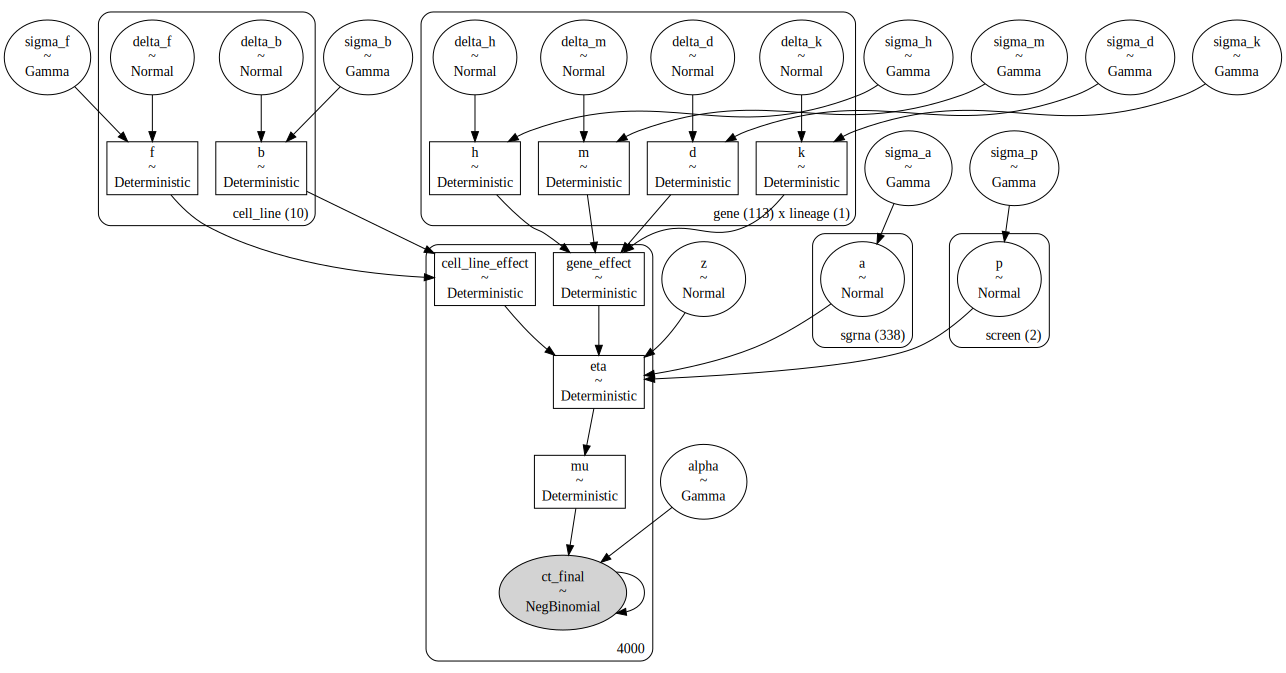

In [19]:
pm.model_to_graphviz(gene_hnb_model)

In [20]:
ppc_vars = ["gene_effect", "cell_line_effect", "eta", "mu", "ct_final"]
with gene_hnb_model:
    gene_ppc = pm.sample_posterior_predictive(
        trace=trace,
        var_names=ppc_vars,
        extend_inferencedata=False,
        return_inferencedata=True,
    )

In [21]:
gene_ppc_df = summarize_posterior_predictions(
    gene_ppc.posterior_predictive["ct_final"].values,
    hdi_prob=HDI_PROB,
    merge_with=hnb.data_processing_pipeline(full_gene_df.copy()),
).assign(pred_lfc=lambda d: np.log(d.pred_mean / d.counts_initial_adj))
gene_ppc_df.head()

,pred_mean,pred_hdi_low,pred_hdi_high,sgrna,hugo_symbol,replicate_id,p_dna_batch,screen,depmap_id,lineage,...,is_mutated,z_rna_gene_lineage,z_cn_gene,z_cn_cell_line,log_rna_expr,counts_final_total,counts_initial_total,counts_final_rpm,counts_initial_adj,pred_lfc
0,693.876,139.0,1247.0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,...,True,-1.566699,-1.061428,-1.061428,0.0,25199342,1.071751e+06,33.143696,576.280879,0.185698
1,815.505,195.0,1402.0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,...,False,-1.566699,-1.061428,-1.061428,0.0,25199342,1.071751e+06,33.143696,576.280879,0.347212
2,698.755,140.0,1212.0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,...,True,-1.566699,-0.713273,-0.713273,0.0,25199342,1.071751e+06,33.143696,576.280879,0.192705
3,808.535,155.0,1382.0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,...,False,-1.566699,-0.713273,-0.713273,0.0,25199342,1.071751e+06,33.143696,576.280879,0.338629
4,658.396,102.0,1116.0,AATCAACCCACAGCTGCACA,TP53,COLO201-311Cas9_RepA_p6_batch3,3,broad,ACH-000253,colorectal,...,True,-1.566699,-0.365118,-0.365118,0.0,25199342,1.071751e+06,33.143696,576.280879,0.133211


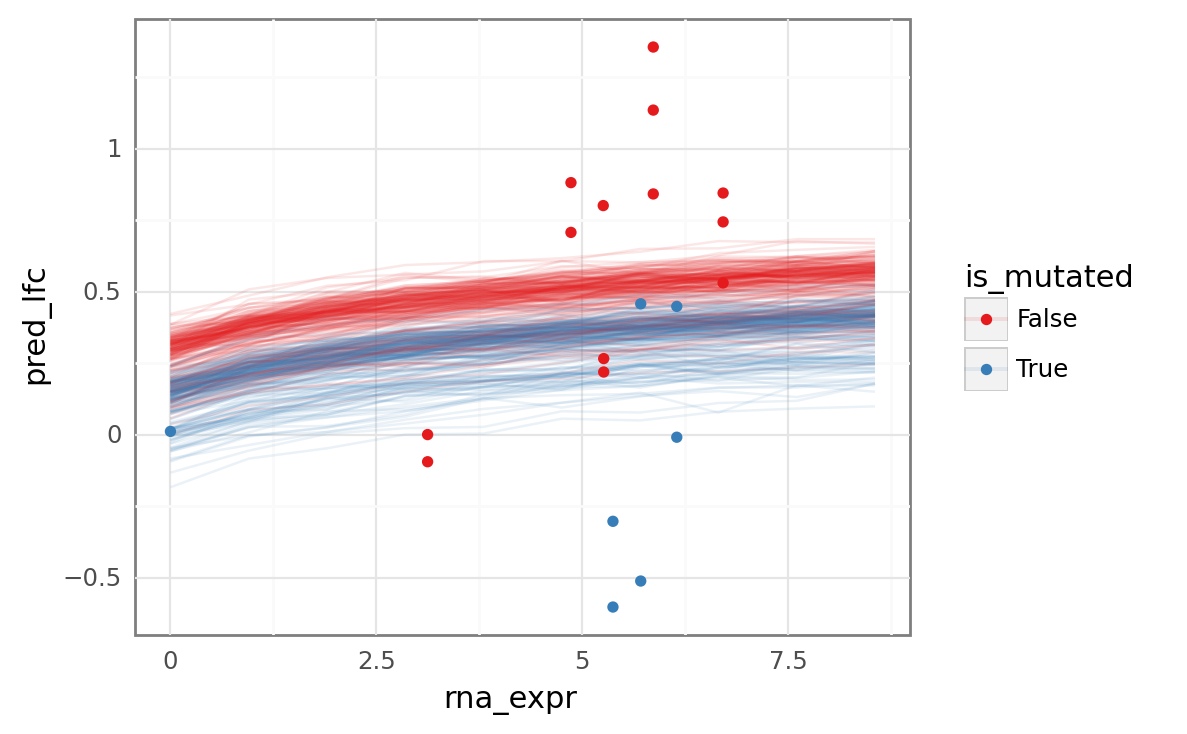

<ggplot: (315893492)>

In [22]:
line_grp = " + ".join(
    [
        f"{x}.astype(str)"
        for x in ["depmap_id", "is_mutated", "sgrna", "screen", "z_cn_gene"]
    ]
)
(
    gg.ggplot(gene_ppc_df, gg.aes(x="rna_expr", y="pred_lfc"))
    + gg.geom_line(gg.aes(group=line_grp, color="is_mutated"), alpha=0.1)
    + gg.geom_point(
        gg.aes(y="lfc", color="is_mutated"),
        data=valid_counts_data.query(f"hugo_symbol == '{gene}'"),
        size=1.3,
    )
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(5, 4))
)

---

In [23]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 20.73 minutes


In [24]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-03-25

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.1.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: post-preds

arviz     : 0.12.0
pymc      : 4.0.0b5
seaborn   : 0.11.2
plotnine  : 0.8.0
matplotlib: 3.5.1
pandas    : 1.4.1
numpy     : 1.22.3

